# Post-process for Entire District

## Description
Once you are happy with the post-processed results through previous notebook, you can then implement the same post-processing steps for the entire district of interest. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.  

Note: The approximate running time for the default setting is about 2 minutes.

## Load Packages

In [1]:
%matplotlib inline
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray
import datacube
from datacube.utils.cog import write_cog
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.plotting import rgb
from skimage.morphology import binary_dilation,disk
from skimage.filters.rank import modal
from skimage.segmentation import expand_labels
from odc.algo import xr_reproject
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,BoundaryNorm
from matplotlib.patches import Patch

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Analysis parameters
* `prediction_map_path`: File path and name of the classification map for the entire district.
* `dict_map`: A dictionary map of class names corresponding to pixel values.
* `output_crs`: Coordinate reference system for output raster files.

In [2]:
prediction_map_path='Results/Land_cover_prediction.tif'
dict_map={'Forest':1,'Grassland':5,'Shrubland':7,'Perennial Cropland':9,'Annual Cropland':10,
          'Wetland':11,'Water Body':12,'Urban Settlement':13,'Bare Land':14} # a dictionary of pixel value for each class
output_crs='epsg:32735' # WGS84/UTM Zone 35S

## External Layers
A few external layers for Rwanda were sourced and prepared in the 'Data/' folder, which are helpful to add information on specific classes. The external layers include:  
* `river_network_shp`: OSM river network shapefile. The OSM layers were sourced from the [Humanitarian OpenStreetMap Team (HOT)](https://data.humdata.org/organization/hot) website.
* `road_network_shp`: OSM road network shapefile.
* `google_building_raster`: A rasterised layer of [Google Open Building](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_Research_open-buildings_v2_polygons) polygons, which consist of outlines of buildings derived from high-resolution 50 cm satellite imagery. As there are many polygons in the original vector layer, we rasterised the layer to 10 m resolution to reduce disk storage and memory required for processing.  
* `wsf2019_raster`: 2019 [World Settlement Footprint (WSF)](https://gee-community-catalog.org/projects/wsf/) layer, a 10m resolution binary mask outlining the extent of human settlements globally derived by means of 2019 multitemporal Sentinel-1 and Sentinel-2 imagery.  
* `hand_raster`: Hydrologically adjusted elevations, i.e. Height Above the Nearest Drainage (hand) derived from the [MERIT Hydro dataset](https://developers.google.com/earth-engine/datasets/catalog/MERIT_Hydro_v1_0_1#description).
* `parks_json`: Boundaries of [national parks or reserve](https://geodata.rw/server/rest/services/basemap/National_Parks/FeatureServer/0) declared or registered by the government in geojson format.
* `wetlands_json`: Boundaries of [declaired swamps borders](https://geodata.rw/server/rest/services/basemap/Wetland/FeatureServer/0) in geojson format.

> Note: In this notebook we have made the data prepared for you to run through the demonstration. If you would like to apply it to your own project, you may need to spend some time sourcing the datasets and do some pre-processing if needed, e.g. clipping to your study area, filtering, rasterisation or vectorisation. Alternatively you can revise this notebook depending on the file format of your data.

In [3]:
river_network_shp='Data/hotosm_rwa_waterways_lines_filtered.shp' # OSM river network data
road_network_shp='Data/hotosm_rwa_roads_lines_filtered.shp' # OSM road network data
google_building_raster='Data/GoogleBuildingLayer_Rwanda_reprojected_rasterised.tif' # rasterised google bulding layer
wsf2019_raster='Data/WSF2019_v1_Rwanda_clipped.tif' # 2019 World Settlement Footprint layer
hand_raster='Data/hand_Rwanda.tif' # Hydrologically adjusted elevations, i.e. height above the nearest drainage (hand)
parks_json='Data/National Parks.geojson' # National parks layer
wetlands_json='Data/Wetland.geojson' # wetlands layer

## Load land cover map and external layers
First let's load the land cover map:

In [4]:
# import land cover map of 2021 and reproject
lc_map=rioxarray.open_rasterio(prediction_map_path).astype(np.uint8).squeeze()

We then load other layers. The OSM road network layer contains multi-lines with various surface attributes. We'll select some major road types and buffer them by 10 metres. Similarly we load and select major waterways from the OSM river network layer.

In [5]:
road_network=gpd.read_file(road_network_shp).to_crs(output_crs) 
road_network=road_network.loc[road_network['surface'].isin(['asphalt', 'paved', 'compacted', 'cobblestone', 
                                                             'concrete', 'metal', 'paving_stones', 
                                                             'paving_stones:30'])] # select road network by attributes
road_network.geometry=road_network.geometry.buffer(10) # buffer the road network by 10m

river_network=gpd.read_file(river_network_shp).to_crs(output_crs) # import OSM river network data and reproject
river_network=river_network.loc[river_network['waterway'].isin(['canal','river'])] # select river network by attribute

We now load the Google buildings, WSF 2019 and 'hand' rasters:

In [6]:
google_buildings=xr.open_dataset(google_building_raster,engine="rasterio").squeeze() # import google bulding layer
hand=xr.open_dataset(hand_raster,engine="rasterio").squeeze() # import hand layer
wsf2019=xr.open_dataset(wsf2019_raster,engine="rasterio").squeeze().astype(np.uint8)

Finally let's load the national parks and wetlands layers, and select the national parks with no agricultural activities:

In [7]:
parks=gpd.read_file(parks_json).to_crs(output_crs)
parks=parks.loc[parks['type'].isin(['National Park','Volcanoes National Park'])]
wetlands=gpd.read_file(wetlands_json).to_crs(output_crs)

## Morphological filtering and apply all rules
We now apply the filtering and all the rules as implemented in the previous notebook:

In [8]:
# convert to numpy array
np_lc_map=lc_map.squeeze().to_numpy()

# --------------------mode filtering for a smoother classification map----------------------#
np_lc_map_postproc=modal(np_lc_map,footprint=disk(1),mask=np_lc_map!=0)

# get geobox
ds_geobox=lc_map.geobox

# merging two cropland classes
np_lc_map_postproc[np_lc_map_postproc==dict_map['Perennial Cropland']]=dict_map['Annual Cropland']

#--------------------reassign Cropland within national parks as Shrubland------------------------#
# rasterise national parks layer
parks_mask=xr_rasterize(gdf=parks,da=lc_map.squeeze(),transform=ds_geobox.transform,crs=output_crs)
np_parks_mask=parks_mask.squeeze().to_numpy()
# apply the rule
np_lc_map_postproc[(np_lc_map_postproc==dict_map['Annual Cropland'])&(np_parks_mask==1)]=dict_map['Shrubland']

#--------------------reassign Urban Settlement within national parks as surrounding classes------------------------#
# make a copy of land cover array
lc_copy=np_lc_map_postproc.copy()
# assign the regions as background (0)
lc_copy[(np_lc_map_postproc==dict_map['Urban Settlement'])&(np_parks_mask==1)]=0
# expand surrounding classes of background pixels
lc_copy_closed=expand_labels(lc_copy,distance=10000)
# identify filled/changed areas
mask=(lc_copy!=lc_copy_closed)
# copy the filled/changed pixels
np_lc_map_postproc[mask]=lc_copy_closed[mask]

#--------------------reassign Wetland outside wetland polygons as Shrubland------------------------#
wetlands_mask=xr_rasterize(gdf=wetlands,da=lc_map.squeeze(),transform=ds_geobox.transform,crs=output_crs)
np_wetlands_mask=wetlands_mask.squeeze().to_numpy()
np_lc_map_postproc[(np_lc_map_postproc==dict_map['Wetland'])&(np_wetlands_mask!=1)]=dict_map['Shrubland']

#------reassign Bare Land and Urban Settlement within DE Africa crop mask as Cropland; Cropland outside the mask as Shrubland------#
# load DE Africa crop mask 2019
dc = datacube.Datacube(app='cropland_extent')
# extract bounding box
x_min,y_min,x_max,y_max=ds_geobox.extent.boundingbox
query = {
    'time': ('2019'),
    'x': (x_min,x_max),
    'y': (y_min,y_max),
    'resolution':(-10, 10),
    'crs':output_crs,
    'output_crs': output_crs,
}
# now load the crop-mask using the query
cm = dc.load(product='crop_mask',**query).squeeze()
np_crop_mask=cm['mask'].to_numpy()
# apply the rules
np_lc_map_postproc[((np_lc_map_postproc==dict_map['Bare Land'])|(np_lc_map_postproc==dict_map['Urban Settlement']))
&(np_crop_mask==1)]=dict_map['Annual Cropland']
np_lc_map_postproc[(np_lc_map_postproc==dict_map['Annual Cropland'])&(np_crop_mask!=1)]=dict_map['Shrubland']

#--------------------assign pixels within OSM river network as Water Body------------------------#
# reproject hand layer
hand=xr_reproject(hand, ds_geobox, resampling="average")
# convert to numpy array
np_hand=hand.to_array().squeeze().to_numpy()
# rasterise river network layer
river_network_mask=xr_rasterize(gdf=river_network,
                                da=lc_map.squeeze(),
                                transform=ds_geobox.transform,
                                crs=output_crs)
# convert to numpy array
np_river_network_mask=river_network_mask.to_numpy()
# apply the rule
np_lc_map_postproc[np_river_network_mask==1]=dict_map['Water Body']

#--------------------make sure water body only present at bottom of watershed or within OSM river network-----------#
# make a copy of land cover array
lc_copy=np_lc_map_postproc.copy()
# assign the regions as background (0)
lc_copy[(np_lc_map_postproc==dict_map['Water Body'])&(np_hand>45)&(np_river_network_mask!=1)]=0
# expand surrounding classes of background pixels
lc_copy_closed=expand_labels(lc_copy,distance=10000)
# identify filled/changed areas
mask=(lc_copy!=lc_copy_closed)
# copy the filled/changed pixels
np_lc_map_postproc[mask]=lc_copy_closed[mask]

#--------------------assign pixels overlapping google building, WSF 2019 and OSM road network as Urban Settlement---------#
# reproject google buildings raster
google_buildings_mask=xr_reproject(google_buildings, ds_geobox, resampling="average")
# convert to numpy array
np_google_buildings_mask=google_buildings_mask.to_array().squeeze().to_numpy()
# reproject WSF 2019 layer
wsf2019=xr_reproject(wsf2019, ds_geobox, resampling="nearest")
# convert to numpy array
np_wsf2019=wsf2019.to_array().squeeze().to_numpy()
# rasterise road network layer
road_network_mask=xr_rasterize(gdf=road_network,
                            da=lc_map.squeeze(),
                            transform=ds_geobox.transform,
                            crs=output_crs)
# convert to numpy
np_road_network_mask=road_network_mask.to_numpy()
# apply rule
np_lc_map_postproc[(np_google_buildings_mask==1)|(np_wsf2019==255)|(np_road_network_mask==1)]=dict_map['Urban Settlement']

#------------------------------reconstruct processed result as Xarray---------------------------------#
# 
lc_map_postproc=xr.DataArray(data=np_lc_map_postproc,dims=['y','x'],
                         coords={'y':lc_map.y.to_numpy(), 'x':lc_map.x.to_numpy()})
# set spatial reference
lc_map_postproc.rio.write_crs(output_crs, inplace=True)

<xarray.DataArray (y: 961, x: 974)>
array([[10, 10, 10, ..., 10, 10, 10],
       [10, 10,  7, ..., 10, 10, 10],
       [10, 10,  7, ..., 10,  7,  7],
       ...,
       [10, 10, 10, ...,  7, 10, 10],
       [10, 10, 10, ..., 13,  7,  7],
       [10, 10, 10, ..., 13, 13, 13]], dtype=uint8)
Coordinates:
  * y            (y) float64 9.775e+06 9.775e+06 ... 9.766e+06 9.766e+06
  * x            (x) float64 8.454e+05 8.454e+05 ... 8.551e+05 8.551e+05
    spatial_ref  int64 0

To compare the post-processed result with initial prediction without post-processing:

Text(0.5, 1.0, 'Classified Image - Postprocessed')

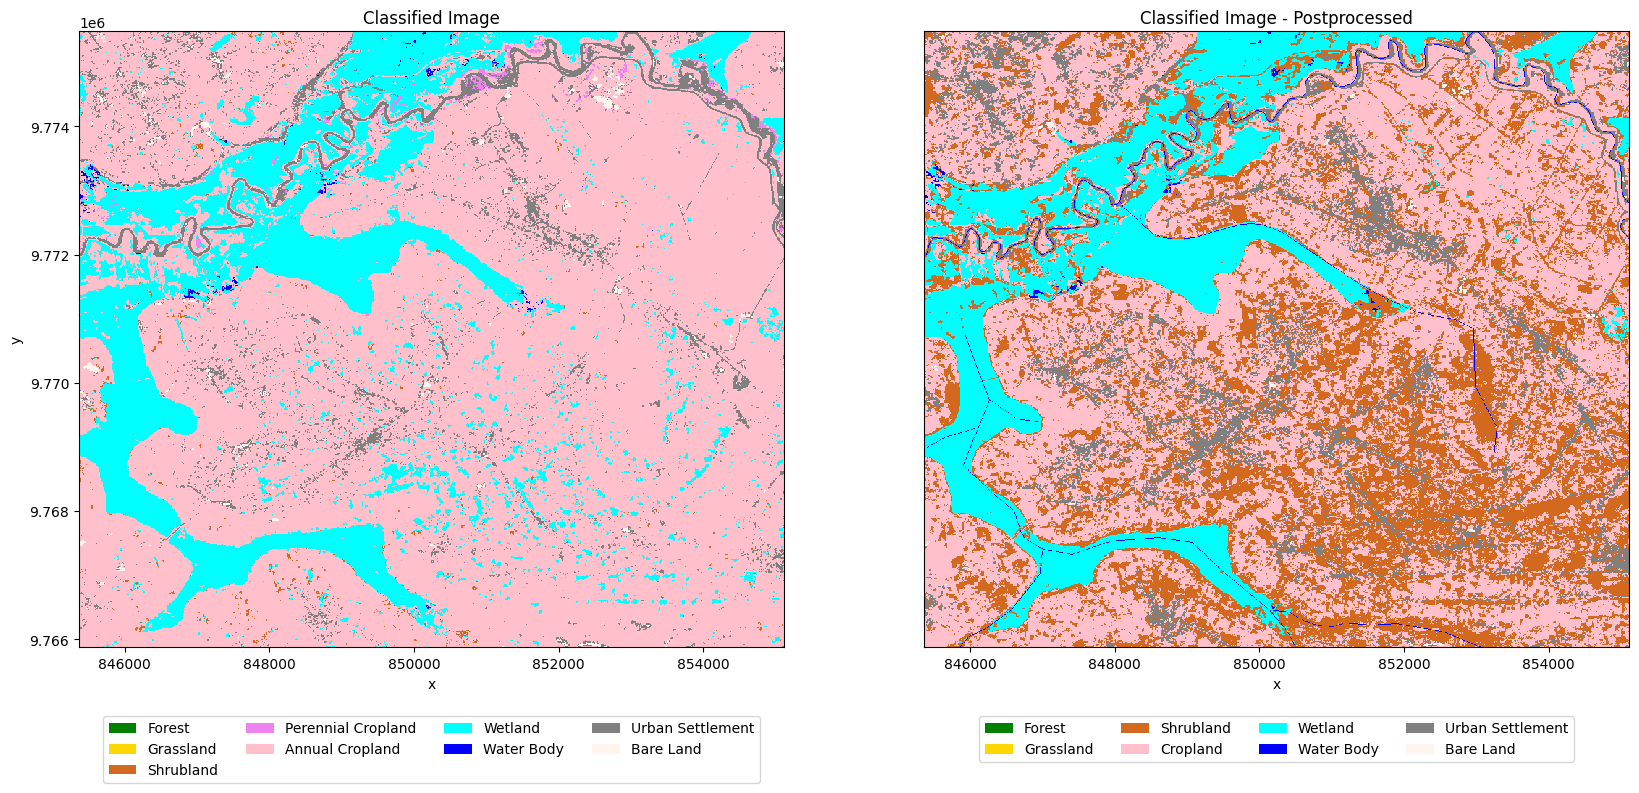

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

dict_map_merged={'Forest':1,'Grassland':5,'Shrubland':7,'Cropland':10,
          'Wetland':11,'Water Body':12,'Urban Settlement':13,'Bare Land':14}

colours = {1:'green', 5:'gold', 7:'chocolate',9:'violet',10:'pink',11:'cyan',12:'blue',13:'gray',14:'seashell'}
colours_merged={1:'green', 5:'gold', 7:'chocolate',10:'pink',11:'cyan',12:'blue',13:'gray',14:'seashell'}

patches_list=[Patch(facecolor=colour) for colour in colours.values()]
patches_list_merged=[Patch(facecolor=colour) for colour in colours_merged.values()]

# set color legends and color maps parameters
prediction_values=np.unique(lc_map)
cmap=ListedColormap([colours[k] for k in prediction_values])
norm = BoundaryNorm(list(prediction_values)+[np.max(prediction_values)+1], cmap.N)

prediction_values_merged=np.unique(lc_map_postproc)
cmap_merged=ListedColormap([colours_merged[k] for k in prediction_values_merged])
norm_merged = BoundaryNorm(list(prediction_values_merged)+[np.max(prediction_values_merged)+1], cmap_merged.N)

# Plot initial classified image
lc_map.plot.imshow(ax=axes[0], 
               cmap=cmap,
               norm=norm,
               add_labels=True, 
               add_colorbar=False,
               interpolation='none')

# Plot post-processed classified image
lc_map_postproc.plot.imshow(ax=axes[1], 
               cmap=cmap_merged,
               norm=norm_merged,
               add_labels=True, 
               add_colorbar=False,
               interpolation='none')

# Remove axis on middle and right plot
axes[1].get_yaxis().set_visible(False)
# add colour legends
axes[0].legend(patches_list, list(dict_map.keys()),
    loc='upper center', ncol =4, bbox_to_anchor=(0.5, -0.1))
axes[1].legend(patches_list_merged, list(dict_map_merged.keys()),
    loc='upper center', ncol =4, bbox_to_anchor=(0.5, -0.1))
# Add plot titles
axes[0].set_title('Classified Image')
axes[1].set_title('Classified Image - Postprocessed')

## Save as geotiff
We can now export our post-processed result to sandbox disk as Cloud-Optimised GeoTIFF:

In [10]:
write_cog(lc_map_postproc, 'Results/Land_cover_prediction_postprocessed.tif', overwrite=True)

PosixPath('Results/Land_cover_prediction_postprocessed.tif')